# Invertible Deep Learning
Let's talk about Invertible Deep Learning.

Deep Learning models are constructed as Directed Acyclic Graphs of simple mathematical transformations. Most of these transformations lose information, but some do not. Also, some transformations lose information but an inverted form can still be reverse-engineered.

This notebook walks through the basics of these invertible deep learning layers, starting with the simplest: activation functions.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_layer(model, name):
    for layer in model.layers:
        if layer.name == name:
            return layer

def create_model(shape, layer):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=shape))
    model.add(layer)
    model.compile(optimizer='sgd', loss='mse')
    return model

def delta_check(data1, data2, epsilon=1e-2):
    delta = np.abs(data1 - data2)
    return np.max(delta) < epsilon

## Invertible Activation Functions

For an activation function to be invertible, it must be a "bijective function". This means that every input value has a unique output value, so that the inverse function can always re-create the input value. For a continuously valued function to be bijective, it must be monotonic (continuously increasing or decreasing). Of the various layers available for our use in Keras, only one is by nature monotonic: the LeakyReLU activation function Layer ([https://keras.io/api/layers/activation_layers/leaky_relu/]).

In [ ]:
leaky = 0.3
forward_leaky_relu = create_model((3,), tf.keras.layers.LeakyReLU(alpha=leaky))
inverted_leaky_relu = create_model((3,), tf.keras.layers.LeakyReLU(alpha=1/leaky))

data = np.array([[-1, 0, 1]])
forward = forward_leaky_relu.predict(data)
print(forward)
inverted = inverted_leaky_relu.predict(forward)
print(inverted)
print(delta_check(data, inverted))

[[-0.3  0.   1. ]]
[[-1.  0.  1.]]
True


We have illustrated that the LeakyReLU function can be fully inverted. Another variant of this is the Parametric ReLU, which supplies a trainable vector of alpha, one for each hidden neuron. This vector is allowed to include negative numbers, which means that Parametric ReLU as specified in the original paper is not monotonic. However, it is possible to modify the algorithm to push all of the alphas into the positive realm, making the function monotonic and invertible. Move this to the "advanced" page.

## Invertible Dense Layers

Matrix transformation layers, along with activation functions, are the most common deep learning tools. Matrices are not natively invertible, but there is a linear algebra tool called the Moore–Penrose inverse which can calculate the inverted version of (almost) any matrix we will encounter in deep learning.

In [ ]:
forward_dense = create_model((3), tf.keras.layers.Dense(3, use_bias=False, name='a'))
inverted_dense = create_model((3), tf.keras.layers.Dense(3, use_bias=False, name='inv_a'))


To demonstrate the Moore-Penrose psuedo-inverse, we will fetch the randomly-initialized weights of the first layer, calculate the pseudo-inverse of those weights, and substitute the pseudo-inverse as the weights of the second layer.

In [ ]:
forward_weights = get_layer(forward_dense, 'a').get_weights()
inverted_weights = np.linalg.pinv(forward_weights)
inverted_dense.set_weights(inverted_weights)

Now, we predict a projected vector with the first model, and project the prediction back to the original vector space (approximately) with the second model.

In [ ]:
data = np.array([[-1, 0, 1]])
forward = forward_dense.predict(data)
print(forward)
inverted = inverted_dense.predict(forward)
print(inverted)
print(delta_check(data, inverted))

[[ 1.3726411   0.37996507 -1.234762  ]]
[[-9.9999994e-01  1.6604527e-07  9.9999994e-01]]
True


Note that the final result here is approximately the same as the input, but not exactly the same. This illustrates that a trained Dense layer can be inverted using the Moore-Penrose pseudo-inverse algorithm.

## Full version of Invertible Dense layer

Of course, the Dense (fully-connected) layer includes a trained "bias" vector, and this vector must be included in any strategy to invert a trained Dense layer. The Dense layer has two stages, with the first being the projective matrix (whose weights we altered above) and then the bias stage.

We cannot the re-order of these stages in the existing Dense layer via the above rewriting strategy, so we will use a Lambda layer. Instead of using the Numpy linear algebra package, we will use the Tensorflow implementation of Moore-Penrose pseudo-inverse transform.

The order of the two stages in an inverted Dense layer is to first subtract the forward layer's bias vector from the input, then project the difference through the Moore-Penrose pseudo-inverse of the forward layer's projection matrix. 

In [ ]:
forward_dense = create_model((3), tf.keras.layers.Dense(3, use_bias=True, name='a'))
forward_layer = get_layer(forward_dense, 'a')
inverted_layer = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_layer.bias, tf.linalg.pinv(forward_layer.kernel)))
inverted_dense = create_model((3), inverted_layer)


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'a/kernel:0' shape=(3, 3) dtype=float32>
  <tf.Variable 'a/bias:0' shape=(3,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


As before, we predict a projected vector with the first model, and project the prediction back to the original vector space (approximately) with the second model.

In [ ]:
data = np.array([[-1, 0, 1]])
forward = forward_dense.predict(data)
print(forward)
inverted = inverted_dense.predict(forward)
print(inverted)
print(delta_check(data, inverted))

[[-1.128732   -0.00526357 -0.4664197 ]]
[[-9.999999e-01  4.560303e-08  1.000000e+00]]
True


This demonstrates that a standard Dense layer in a Keras model can be fully inverted- subject to some constraints. These demonstrations have only used square matrices, where the matrix does not "throw away information" when projecting a vector. A normal deep learning model has a series of differently sized hidden vectors in order to establish a vector space that only contains what is interesting about the dataset, and throws away what is redundant in the dataset. We will address this in the following section- we will train a model using the "accordion" style of autoencoder and illustrate that a trained Dense layer can be inverted, but can only invert inputs that are consonant with the training dataset.

# Palindromic Deep Learning

Next, using the techniques shown above, we will create a simple autoencoder in Keras that is a palindrome: a series of "forward" and "inverted" layers in matched pairs. 

First, let's crib some MNIST code from other Keras examples and design the model.

In [ ]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


The model will create a mirrored sequence of layers based on the techniques for inverting LeakyReLU and Dense demonstrated above.

In [ ]:
def create_palindromic_model():
    alpha = 0.3
    input_img = tf.keras.Input(shape=(784,))
    forward_a = tf.keras.layers.Dense(192, name='a')
    forward_b = tf.keras.layers.Dense(128, name='b')
    forward_c = tf.keras.layers.Dense(64, name='c')
    inverted_c = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_c.bias, tf.linalg.pinv(forward_c.kernel)))
    inverted_b = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_b.bias, tf.linalg.pinv(forward_b.kernel)))
    inverted_a = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_a.bias, tf.linalg.pinv(forward_a.kernel)))

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(forward_a)
    model.add(tf.keras.layers.LeakyReLU(alpha))
    model.add(forward_b)
    model.add(tf.keras.layers.LeakyReLU(alpha))
    model.add(forward_c)
    model.add(inverted_c)
    model.add(tf.keras.layers.LeakyReLU(1/alpha))
    model.add(inverted_b)
    model.add(tf.keras.layers.LeakyReLU(1/alpha))
    model.add(inverted_a)

    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

autoencoder = create_palindromic_model()


The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'c/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'c/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'b/kernel:0' shape=(192, 128) dtype=float32>
  <tf.Variable 'b/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_3), but
are not present in its tracked objects:
  <tf.Variable 'a/kernel:0' shape=(784, 192)

In [ ]:
num_epochs =  1000  # @param {type: "slider", min:2, max:1000}
batch_size = 3072

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping],
                verbose=2)


Epoch 1/1000
20/20 - 3s - loss: 0.1279 - val_loss: 0.0746 - 3s/epoch - 134ms/step
Epoch 2/1000
20/20 - 2s - loss: 0.0748 - val_loss: 0.0606 - 2s/epoch - 81ms/step
Epoch 3/1000
20/20 - 2s - loss: 0.0617 - val_loss: 0.0503 - 2s/epoch - 81ms/step
Epoch 4/1000
20/20 - 2s - loss: 0.0518 - val_loss: 0.0433 - 2s/epoch - 82ms/step
Epoch 5/1000
20/20 - 2s - loss: 0.0456 - val_loss: 0.0388 - 2s/epoch - 79ms/step
Epoch 6/1000
20/20 - 2s - loss: 0.0415 - val_loss: 0.0355 - 2s/epoch - 78ms/step
Epoch 7/1000
20/20 - 2s - loss: 0.0384 - val_loss: 0.0328 - 2s/epoch - 79ms/step
Epoch 8/1000
20/20 - 1s - loss: 0.0359 - val_loss: 0.0307 - 1s/epoch - 70ms/step
Epoch 9/1000
20/20 - 1s - loss: 0.0339 - val_loss: 0.0289 - 1s/epoch - 69ms/step
Epoch 10/1000
20/20 - 1s - loss: 0.0322 - val_loss: 0.0274 - 1s/epoch - 69ms/step
Epoch 11/1000
20/20 - 1s - loss: 0.0308 - val_loss: 0.0260 - 1s/epoch - 69ms/step
Epoch 12/1000
20/20 - 1s - loss: 0.0296 - val_loss: 0.0249 - 1s/epoch - 70ms/step
Epoch 13/1000
20/20 - 1s

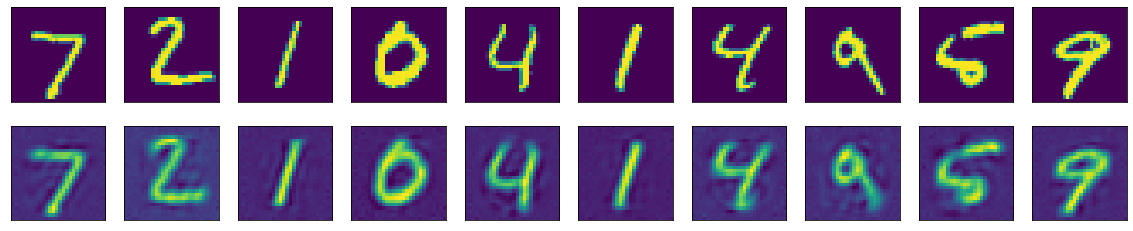

In [ ]:
n = 10  # How many digits we will display
# display_imgs = x_test.take(n)
predicted_imgs = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As you can see, this design is a decent autoencoder. Not the best around, but the output is recognizable. 